# 3. Cluster Analysis

This notebook performs a cluster analysis on the data set df_trips based on various parameters and also includes clustering based on weather and spatial features.

**Task** <br>
Based	on	the	bike	 rental	demand	patterns,	 can	you	identify	 clusters	of	trip	types	
and/or	customer	types?	How	would	you	label	these	clusters?	Can	you	identify	hot	 spots	for	vehicle	
availability and	demand	in	spatial	resolution?
Methods: Identify	clusters	with	soft-clustering	and	visualize	your	results.	Compare	your	results	to	a	
hard-clustering	method of	your	choice.	

**Structure**
1. trips
2. weather-based
3. spatial


In [ ]:
import vaex
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture

In [7]:
df_trips = vaex.open('data/trips/trips_prepared.hdf5')

# for testing with reduced lines
df_trips = df_trips.sample(n=100000, random_state=42)

In [8]:
df_trips.info()

column,type,unit,description,expression
Taxi ID_encoded,int64,,,
Company,str,,,
Company_encoded,int64,,,
ts_start,datetime64[us],,,
ts_end,datetime64[us],,,
start_day,datetime64[us],,,
start_weekday,int32,,,
start_month,int32,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,


In [9]:
trip_attributes          = ['start_month', 'start_weekday', 'start_1_hour', 'Trip Seconds', 'Trip Total']
trip_clustering_features = ['start_month', 'start_weekday_sin', 'start_weekday_cos', 'start_1_hour_sin','start_1_hour_cos', 'Trip Seconds', 'Trip Total']

trip_clustering_df          = df_trips[trip_attributes].to_pandas_df()
trip_clustering_unscaled_df = df_trips[trip_clustering_features].to_pandas_df()

KeyboardInterrupt: 

In [ ]:
trip_clustering_df

,start_month,start_weekday,start_1_hour,Trip Seconds,Trip Total
0,1,1,8,840.0,9.75
1,2,5,22,1108.0,15.25
2,11,4,23,600.0,10.65
3,3,6,11,0.0,3.25
4,3,4,22,360.0,7.55
...,...,...,...,...,...
99995,8,1,17,591.0,9.85
99996,3,2,18,360.0,6.05
99997,8,2,11,320.0,6.65
99998,1,3,11,627.0,9.65


https://www.kaggle.com/code/emilytries/clustering-and-feature-selection/notebook

In [ ]:
trip_clustering_df.fillna(0, inplace=True)
trip_clustering_unscaled_df.fillna(0, inplace=True)

In [ ]:
def outlier_thresholds(dataframe, variable):
    lower_quantile = dataframe[variable].quantile(0.025)
    upper_quantile = dataframe[variable].quantile(0.975)
    interquantile_range = upper_quantile - lower_quantile
    up_limit  = upper_quantile + 1.5 * interquantile_range
    low_limit = lower_quantile - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def remove_all_outliers(dataframe):
    for col in dataframe.columns:
        replace_with_thresholds(dataframe, col)

In [ ]:
remove_all_outliers(trip_clustering_df)
remove_all_outliers(trip_clustering_unscaled_df)

In [ ]:
trip_clustering_unscaled_df

,start_month,start_weekday_sin,start_weekday_cos,start_1_hour_sin,start_1_hour_cos,Trip Seconds,Trip Total
0,1.0,0.781831,0.623490,0.866025,-5.000000e-01,840.0,9.75
1,2.0,-0.974928,-0.222521,-0.500000,8.660254e-01,1108.0,15.25
2,11.0,-0.433884,-0.900969,-0.258819,9.659258e-01,600.0,10.65
3,3.0,-0.781831,0.623490,0.258819,-9.659258e-01,0.0,3.25
4,3.0,-0.433884,-0.900969,-0.500000,8.660254e-01,360.0,7.55
...,...,...,...,...,...,...,...
99995,8.0,0.781831,0.623490,-0.965926,-2.588190e-01,591.0,9.85
99996,3.0,0.974928,-0.222521,-1.000000,-1.836970e-16,360.0,6.05
99997,8.0,0.974928,-0.222521,0.258819,-9.659258e-01,320.0,6.65
99998,1.0,0.433884,-0.900969,0.258819,-9.659258e-01,627.0,9.65


Check for missing values

In [ ]:
trip_clustering_unscaled_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   start_month        100000 non-null  float64
 1   start_weekday_sin  100000 non-null  float64
 2   start_weekday_cos  100000 non-null  float64
 3   start_1_hour_sin   100000 non-null  float64
 4   start_1_hour_cos   100000 non-null  float64
 5   Trip Seconds       100000 non-null  float64
 6   Trip Total         100000 non-null  float64
dtypes: float64(7)
memory usage: 5.3 MB


In [ ]:
def plt_corr(dataframe):
    base_df_corr = dataframe.corr()
    mask = np.triu(np.ones_like(base_df_corr, dtype=bool))
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figwidth(20)
    sns.heatmap(base_df_corr, annot = True, vmax= 1, vmin= -1, center=0, cmap='vlag', mask = mask)
    plt.show()

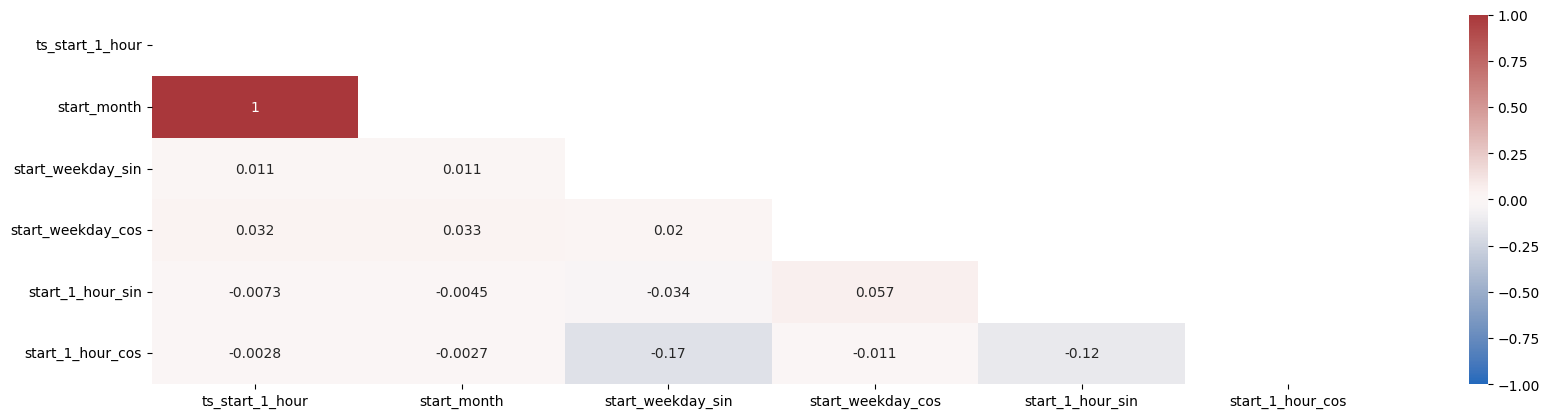

In [ ]:
plt_corr(trip_clustering_unscaled_df)

In [43]:
def scale_df(dataframe):
    scaler = StandardScaler()
    scaler.fit(dataframe)
    dataframe_scaled = scaler.transform(dataframe)

    scaled_df = pd.DataFrame(dataframe_scaled, columns = dataframe.columns, index = dataframe.index)

    return scaled_df

In [ ]:
trip_clustering_scaled_df = scale_df(trip_clustering_unscaled_df)

,start_month,start_weekday_sin,start_weekday_cos,start_1_hour_sin,start_1_hour_cos,Trip Seconds,Trip Total
0,1.0,0.781831,0.623490,0.866025,-5.000000e-01,840.0,9.75
1,2.0,-0.974928,-0.222521,-0.500000,8.660254e-01,1108.0,15.25
2,11.0,-0.433884,-0.900969,-0.258819,9.659258e-01,600.0,10.65
3,3.0,-0.781831,0.623490,0.258819,-9.659258e-01,0.0,3.25
4,3.0,-0.433884,-0.900969,-0.500000,8.660254e-01,360.0,7.55
...,...,...,...,...,...,...,...
99995,8.0,0.781831,0.623490,-0.965926,-2.588190e-01,591.0,9.85
99996,3.0,0.974928,-0.222521,-1.000000,-1.836970e-16,360.0,6.05
99997,8.0,0.974928,-0.222521,0.258819,-9.659258e-01,320.0,6.65
99998,1.0,0.433884,-0.900969,0.258819,-9.659258e-01,627.0,9.65


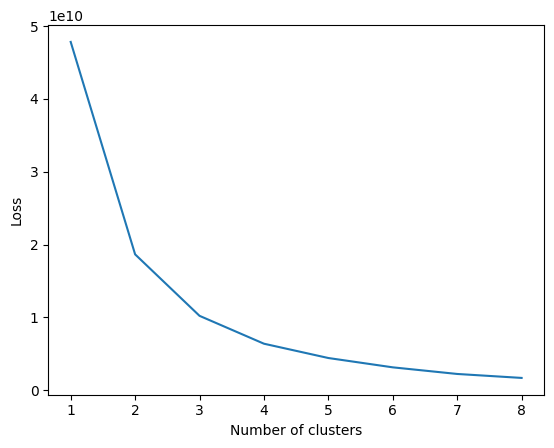

In [ ]:
# Grid search for the optimum number of clusters with KMean  
# Source: Data Mining for Business Analytics by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel: Chapter 15.10

k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
    model.fit(trip_clustering_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [ ]:
trip_model_k_means = KMeans(n_clusters = 3, n_init=10, init="k-means++", random_state=42)
trip_model_k_means.fit(trip_clustering_scaled_df)

trip_clustering_df['cluster_k_means'] = trip_model_k_means.predict(trip_clustering_scaled_df)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans

In [ ]:
trip_model_bisecting_k_means = BisectingKMeans(n_clusters = 3, init="k-means++", random_state=42)
trip_model_bisecting_k_means.fit(trip_clustering_scaled_df)
trip_clustering_df['cluster_bisecting_k_means'] = trip_model_k_means.predict(trip_clustering_scaled_df)

trip_model_bisecting_k_means.cluster_centers_

array([[ 6.69091935e+00, -1.79827777e-03, -4.48145075e-02,
        -2.33783097e-01, -1.65831692e-01,  1.69651358e+03,
         3.15432024e+01],
       [ 6.91012114e+00,  1.50552697e-01, -1.36649102e-01,
        -3.48431872e-01, -3.59684750e-01,  3.48210903e+03,
         4.59071493e+01],
       [ 6.64844173e+00, -5.67271930e-02, -5.91162303e-02,
        -2.24347060e-01, -1.54285316e-02,  4.88729084e+02,
         1.01233221e+01]])

In [ ]:
# soft clustering with gaussian mixture model
gmm_trips = GaussianMixture(n_components = 3, random_state = 42)
gmm_trips.fit(trip_clustering_scaled_df)

# retrieve assigned cluster labels
trip_clustering_df['cluster_gmm'] = gmm_trips.predict(trip_clustering_scaled_df)

# check convergence
print(gmm_trips.converged_)

True


In [ ]:
trip_clustering_df

,start_month,start_weekday,start_1_hour,Trip Seconds,Trip Total,cluster_k_means,cluster_bisecting_k_means,cluster_gmm
0,1.0,1,8.0,840.0,9.75,2,2,1
1,2.0,5,22.0,1108.0,15.25,2,2,0
2,11.0,4,23.0,600.0,10.65,1,1,1
3,3.0,6,11.0,0.0,3.25,1,1,1
4,3.0,4,22.0,360.0,7.55,1,1,1
...,...,...,...,...,...,...,...,...
99995,8.0,1,17.0,591.0,9.85,1,1,1
99996,3.0,2,18.0,360.0,6.05,1,1,1
99997,8.0,2,11.0,320.0,6.65,1,1,1
99998,1.0,3,11.0,627.0,9.65,1,1,1


In [74]:
 def plt_violins(dataframe):
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))

        fig, axes = plt.subplots(nrows = len(feature_cols) + 1, ncols = len(cluster_cols), figsize = (20,15))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                for feature_id, feat in enumerate(feature_cols):
                        sns.violinplot(ax = axes[feature_id, cluster_id], x=dataframe[cluster_col], y=dataframe[feat], data=dataframe)
                        axes[feature_id, cluster_id].set_title(f'{cluster_col} - {feat}')
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[len(feature_cols), cluster_id].bar(cluster_size.index, cluster_size)
                axes[len(feature_cols), cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

In [ ]:
plt_violins(trip_clustering_df)

## Weather/trip clustering

In [ ]:
weather_df = pd.read_pickle("data/weather.pickle")
weather_df

,Temperature,Humidity,Wind Speed,Precip.,cloud,rain,Fair,Fog,Snow,T-Storm,Thunder
datetime,,,,,,,,,,,
2014-01-01 00:00:00,-10.0,84.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 01:00:00,-8.9,84.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 02:00:00,-8.3,84.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 03:00:00,-7.8,84.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 04:00:00,-7.2,85.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,-7.2,47.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2014-12-31 20:00:00,-7.2,50.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2014-12-31 21:00:00,-6.7,48.0,17.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#weather_attributes = ['Temperature', 'Humidity', 'Wind Speed', 'Precip.', 'cloud', 'rain', 'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder']
weather_attributes = ['Temperature', 'Precip.', 'cloud']

weather_df = weather_df[weather_attributes]

In [ ]:
df_trips = vaex.open('data/trips/trips_prepared.hdf5')

# for testing with reduced lines
df_trips = df_trips.sample(n=100000, random_state=42)

In [ ]:
trip_attributes          = ['ts_start_1_hour']#, 'start_month', 'start_weekday', 'start_1_hour']
trip_clustering_features = ['ts_start_1_hour']#, 'start_month', 'start_weekday_sin', 'start_weekday_cos', 'start_1_hour_sin','start_1_hour_cos']

trip_clustering_df          = df_trips[trip_attributes].to_pandas_df()
trip_clustering_unscaled_df = df_trips[trip_clustering_features].to_pandas_df()

Join trips and weather

In [ ]:
trip_weather_clustering_df = trip_clustering_df.merge(weather_df, left_on='ts_start_1_hour', right_on='datetime', how='left')
trip_weather_clustering_unscaled_df = trip_clustering_unscaled_df.merge(weather_df, left_on='ts_start_1_hour', right_on='datetime', how='left')

trip_weather_clustering_df.drop(columns=['ts_start_1_hour'], inplace=True)
trip_weather_clustering_unscaled_df.drop(columns=['ts_start_1_hour'], inplace=True)


In [ ]:
trip_weather_clustering_unscaled_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Temperature  100000 non-null  float64
 1   Precip.      100000 non-null  float64
 2   cloud        100000 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB


In [ ]:
# scaling trip_df with the go-to scaling in industry
scaler = StandardScaler()
scaler.fit(trip_weather_clustering_unscaled_df)
trip_weather_clustering_scaled = scaler.transform(trip_weather_clustering_unscaled_df)

trip_weather_clustering_scaled_df = pd.DataFrame(trip_weather_clustering_scaled, columns = trip_weather_clustering_unscaled_df.columns, index = trip_weather_clustering_unscaled_df.index)

In [ ]:
trip_weather_clustering_scaled_df

,Temperature,Precip.,cloud
0,-2.255735,-0.098735,-1.311247
1,-1.199157,-0.098735,1.136327
2,-1.199157,-0.098735,0.320469
3,-1.389010,-0.098735,0.320469
4,-0.192105,-0.098735,1.136327
...,...,...,...
99995,1.458799,-0.098735,-0.495389
99996,-0.654358,-0.098735,0.320469
99997,1.227672,-0.098735,0.320469
99998,-1.017557,-0.098735,1.136327


## Correlation analysis of weather_df

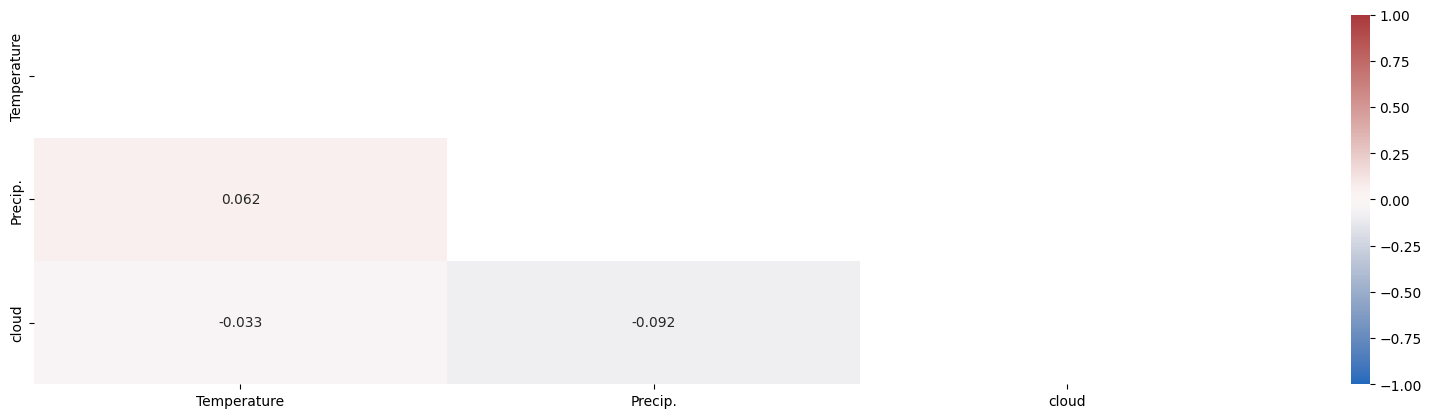

In [ ]:
plt_corr(trip_weather_clustering_scaled_df)

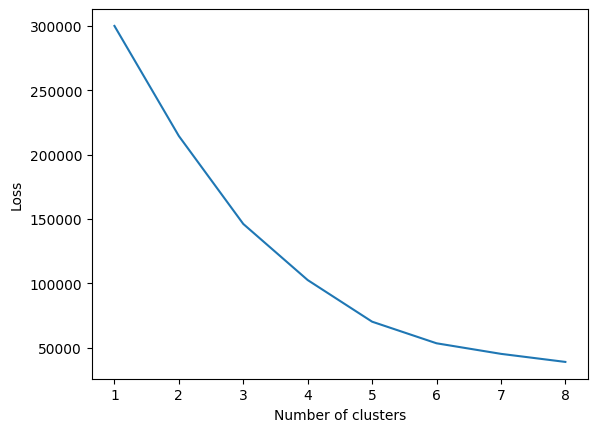

In [ ]:
# Grid search for the optimum number of clusters with KMean  
# Source: Data Mining for Business Analytics by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel: Chapter 15.10

k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
    model.fit(trip_weather_clustering_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [ ]:
trip_weather_model_k_means = KMeans(n_clusters = 3, n_init=10, init="k-means++", random_state=42)
trip_weather_model_k_means.fit(trip_weather_clustering_scaled_df)

trip_weather_clustering_df['cluster_k_means'] = trip_weather_model_k_means.predict(trip_weather_clustering_scaled_df)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans

In [ ]:
trip_weather_model_bisecting_k_means = BisectingKMeans(n_clusters = 3, init="k-means++", random_state=42)
trip_weather_model_bisecting_k_means.fit(trip_weather_clustering_scaled_df)
trip_weather_clustering_df['cluster_bisecting_k_means'] = trip_weather_model_bisecting_k_means.predict(trip_weather_clustering_scaled_df)

trip_weather_model_bisecting_k_means.cluster_centers_

array([[-9.17518501e-01, -8.79446834e-02,  2.36068129e-01],
       [ 7.61949491e-01, -4.86318893e-03, -1.92249273e-01],
       [ 8.60533725e-01,  1.61197180e+01, -1.00221015e+00]])

In [ ]:
# soft clustering with gaussian mixture model
gmm_trips = GaussianMixture(n_components = 3, random_state = 42)
gmm_trips.fit(trip_weather_clustering_scaled_df)

# retrieve assigned cluster labels
trip_weather_clustering_df['cluster_gmm'] = gmm_trips.predict(trip_weather_clustering_scaled_df)

# check convergence
print(gmm_trips.converged_)

True


In [ ]:
trip_weather_clustering_df

,Temperature,Precip.,cloud,cluster_k_means,cluster_bisecting_k_means,cluster_gmm
0,-16.1,0.0,0.0,1,0,0
1,-3.3,0.0,3.0,0,0,0
2,-3.3,0.0,2.0,0,0,0
3,-5.6,0.0,2.0,0,0,0
4,8.9,0.0,3.0,0,0,0
...,...,...,...,...,...,...
99995,28.9,0.0,1.0,1,1,1
99996,3.3,0.0,2.0,0,0,0
99997,26.1,0.0,2.0,0,1,1
99998,-1.1,0.0,3.0,0,0,0


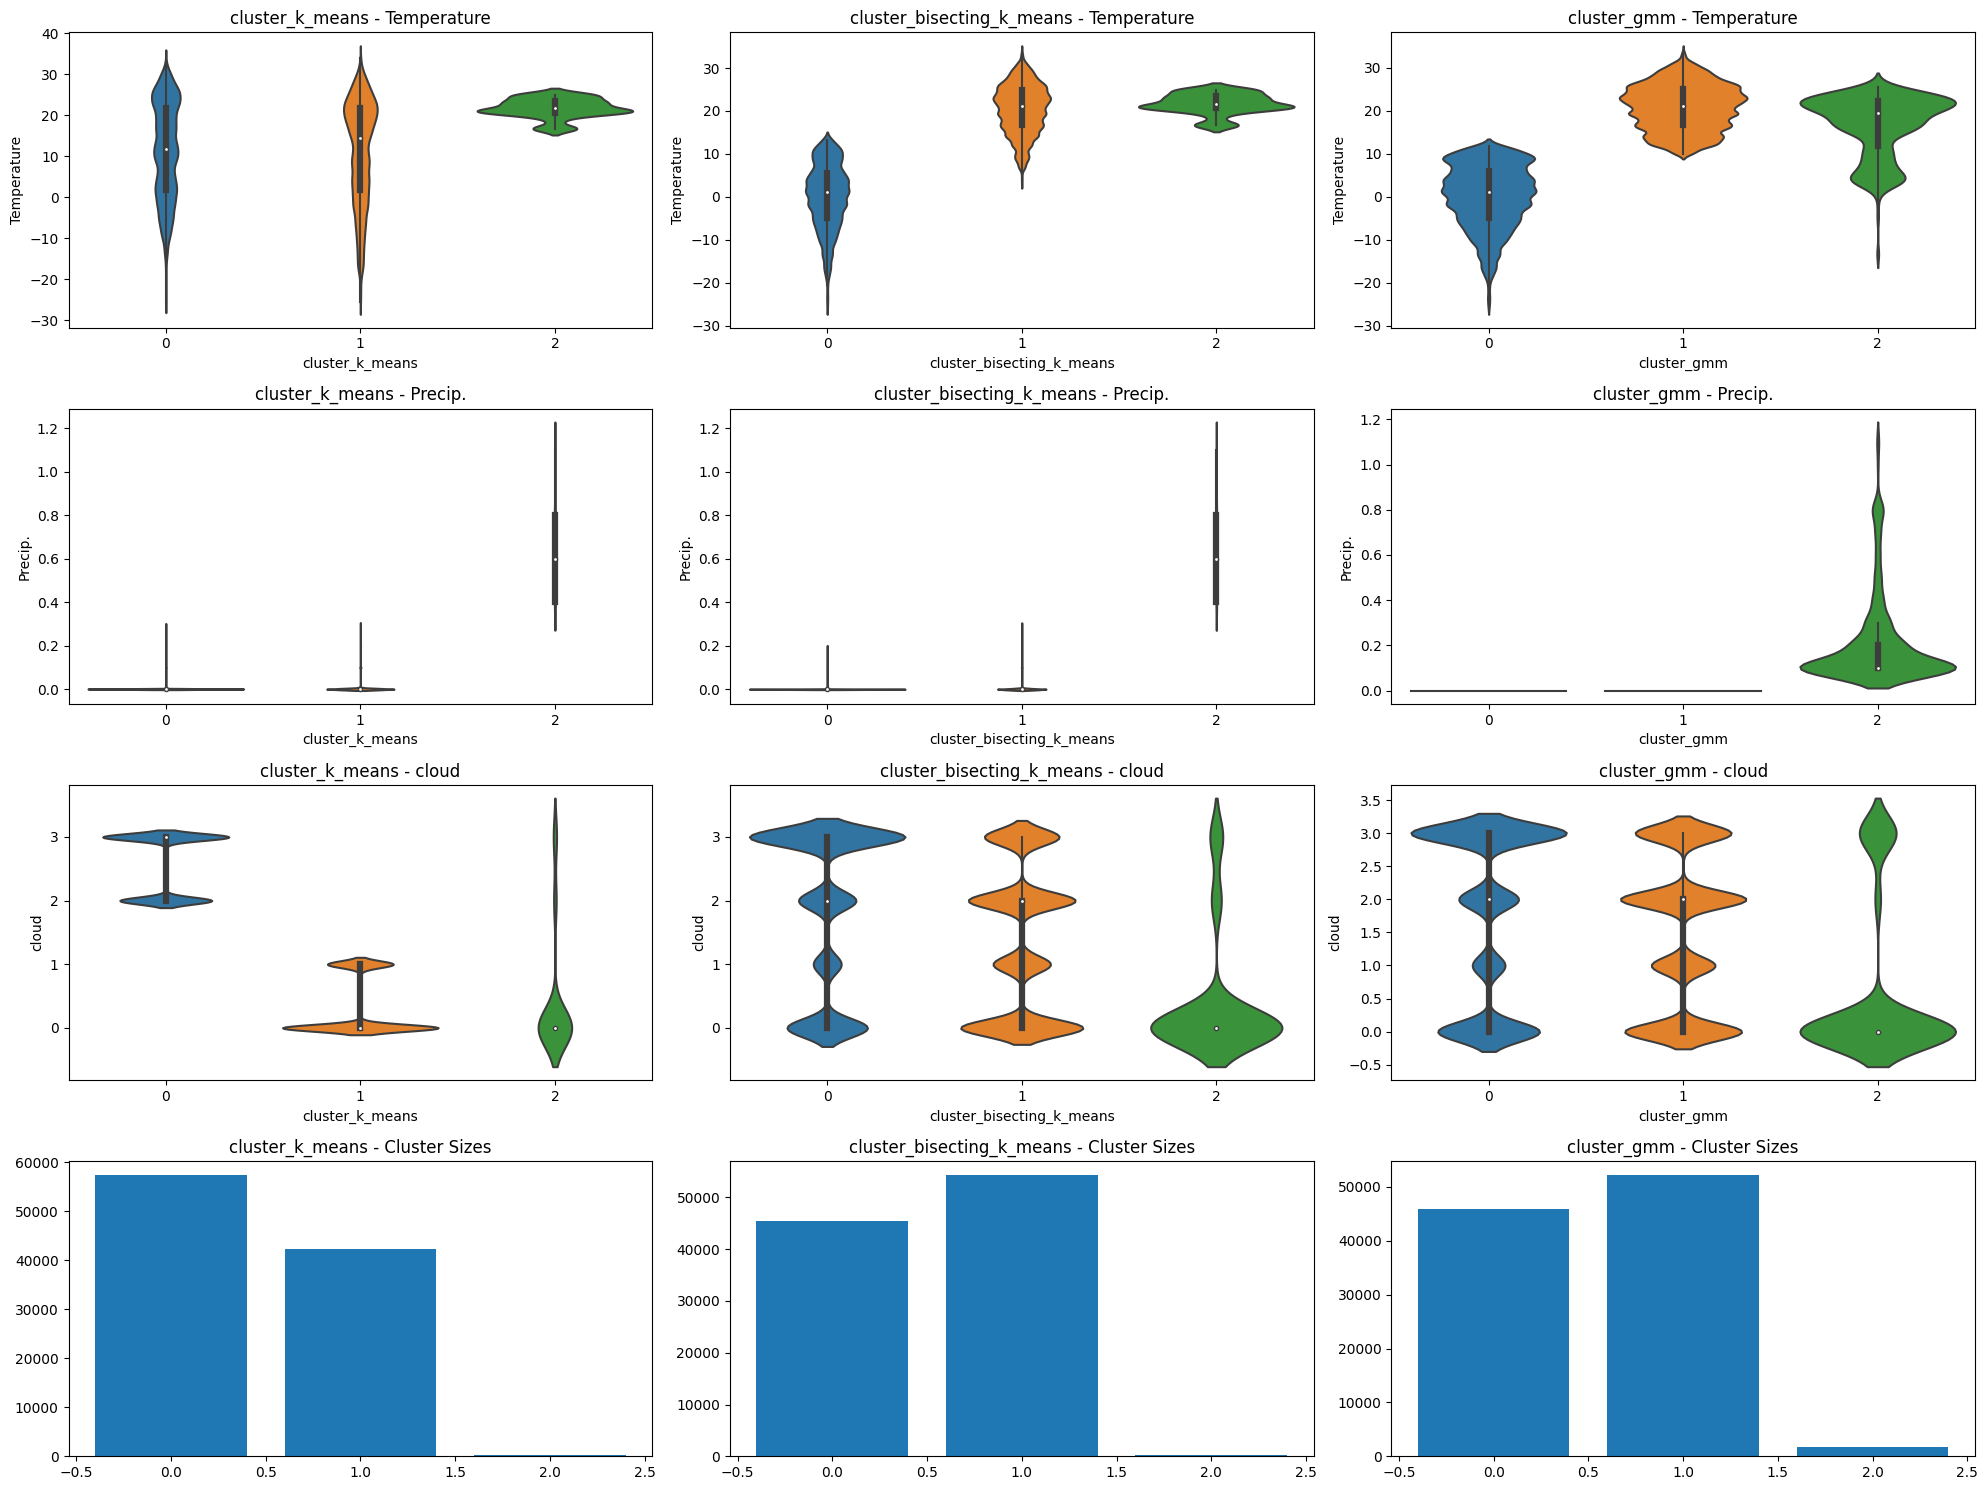

In [ ]:
plt_violins(trip_weather_clustering_df)

# Spatial Clustering

In [170]:
# Separate weekend from weekday trips
df_trips_weekend = df_trips[df_trips['start_weekday'] >= 5]
df_trips_weekday = df_trips[df_trips['start_weekday'] >  5]

In [171]:
group_cols = ['pickup_hex_7', 'start_1_hour']

In [172]:
df_trips_weekend = df_trips_weekend.groupby(by=group_cols, progress=True).agg({'demand':'count'})
df_trips_weekday = df_trips_weekday.groupby(by=group_cols, progress=True).agg({'demand':'count'})

groupby [########################################] 100.00% elapsed time  :     0.10s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.12s =  0.0m =  0.0h
 

In [173]:
spatial_start_hour_weekend_clustering_df = df_trips_weekend.to_pandas_df()
spatial_start_hour_weekday_clustering_df = df_trips_weekday.to_pandas_df()

In [174]:
spatial_start_hour_weekday_clustering_df

,pickup_hex_7,start_1_hour,demand
0,872c21cd9ffffff,0,2
1,872c21cd9ffffff,1,1
2,872c21cd9ffffff,2,1
3,872c21cd9ffffff,4,1
4,872c21cd9ffffff,5,1
...,...,...,...
413,872c21cdeffffff,10,2
414,872c21cdeffffff,11,1
415,872c21cdeffffff,14,1
416,872c21cdeffffff,21,1


In [175]:
spatial_start_hour_weekday_clustering_df.set_index(group_cols, inplace=True)
spatial_start_hour_weekend_clustering_df.set_index(group_cols, inplace=True)

In [176]:
spatial_start_hour_weekday_clustering_df

demand
pickup_hex_7    start_1_hour        
872c21cd9ffffff 0                  2
                1                  1
                2                  1
                4                  1
                5                  1
...                              ...
872c21cdeffffff 10                 2
                11                 1
                14                 1
                21                 1
                22                 1

[418 rows x 1 columns]

In [177]:
spatial_start_hour_weekend_unstacked_clustering_df = spatial_start_hour_weekend_clustering_df['demand'].unstack().fillna(0)
spatial_start_hour_weekday_unstacked_clustering_df = spatial_start_hour_weekday_clustering_df['demand'].unstack().fillna(0)

In [178]:
spatial_start_hour_weekend_unstacked_clustering_df

start_1_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
pickup_hex_7,,,,,,,,,,,,,,,,,,,,,
NaN,118.0,98.0,93.0,58.0,26.0,24.0,20.0,28.0,42.0,54.0,...,78.0,84.0,72.0,83.0,86.0,90.0,90.0,81.0,89.0,94.0
872c21002ffffff,11.0,18.0,9.0,12.0,10.0,14.0,8.0,6.0,3.0,9.0,...,7.0,6.0,13.0,6.0,11.0,7.0,5.0,11.0,13.0,12.0
872c21003ffffff,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
872c21010ffffff,51.0,58.0,35.0,18.0,14.0,9.0,17.0,26.0,31.0,39.0,...,67.0,83.0,77.0,88.0,83.0,92.0,106.0,109.0,75.0,60.0
872c21011ffffff,1.0,3.0,2.0,4.0,0.0,4.0,0.0,0.0,0.0,2.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
872c21014ffffff,4.0,5.0,8.0,9.0,7.0,8.0,3.0,1.0,3.0,3.0,...,3.0,0.0,2.0,2.0,7.0,3.0,4.0,2.0,4.0,8.0
872c21015ffffff,16.0,13.0,17.0,6.0,5.0,9.0,8.0,14.0,11.0,7.0,...,10.0,15.0,12.0,10.0,8.0,18.0,18.0,11.0,16.0,22.0
872c21016ffffff,57.0,54.0,47.0,37.0,22.0,17.0,25.0,16.0,16.0,28.0,...,32.0,21.0,37.0,40.0,38.0,39.0,45.0,44.0,49.0,47.0
872c2118affffff,261.0,242.0,248.0,180.0,96.0,56.0,18.0,25.0,31.0,60.0,...,81.0,88.0,96.0,90.0,144.0,124.0,132.0,157.0,154.0,157.0


In [179]:
spatial_start_hour_weekend_unstacked_clustering_df.head()

start_1_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
pickup_hex_7,,,,,,,,,,,,,,,,,,,,,
NaN,118.0,98.0,93.0,58.0,26.0,24.0,20.0,28.0,42.0,54.0,...,78.0,84.0,72.0,83.0,86.0,90.0,90.0,81.0,89.0,94.0
872c21002ffffff,11.0,18.0,9.0,12.0,10.0,14.0,8.0,6.0,3.0,9.0,...,7.0,6.0,13.0,6.0,11.0,7.0,5.0,11.0,13.0,12.0
872c21003ffffff,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
872c21010ffffff,51.0,58.0,35.0,18.0,14.0,9.0,17.0,26.0,31.0,39.0,...,67.0,83.0,77.0,88.0,83.0,92.0,106.0,109.0,75.0,60.0
872c21011ffffff,1.0,3.0,2.0,4.0,0.0,4.0,0.0,0.0,0.0,2.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [180]:
spatial_start_hour_weekend_unstacked_clustering_df.head()

start_1_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
pickup_hex_7,,,,,,,,,,,,,,,,,,,,,
NaN,118.0,98.0,93.0,58.0,26.0,24.0,20.0,28.0,42.0,54.0,...,78.0,84.0,72.0,83.0,86.0,90.0,90.0,81.0,89.0,94.0
872c21002ffffff,11.0,18.0,9.0,12.0,10.0,14.0,8.0,6.0,3.0,9.0,...,7.0,6.0,13.0,6.0,11.0,7.0,5.0,11.0,13.0,12.0
872c21003ffffff,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
872c21010ffffff,51.0,58.0,35.0,18.0,14.0,9.0,17.0,26.0,31.0,39.0,...,67.0,83.0,77.0,88.0,83.0,92.0,106.0,109.0,75.0,60.0
872c21011ffffff,1.0,3.0,2.0,4.0,0.0,4.0,0.0,0.0,0.0,2.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [181]:
weekend_T = spatial_start_hour_weekend_unstacked_clustering_df.T
weekday_T = spatial_start_hour_weekday_unstacked_clustering_df.T

In [182]:
weekend_T.columns = weekend_T.columns.astype(str)
weekday_T.columns = weekday_T.columns.astype(str)

In [183]:
spatial_start_hour_weekend_unstacked_clustering_scaled_df = scale_df(weekend_T)
spatial_start_hour_weekday_unstacked_clustering_scaled_df = scale_df(weekday_T)

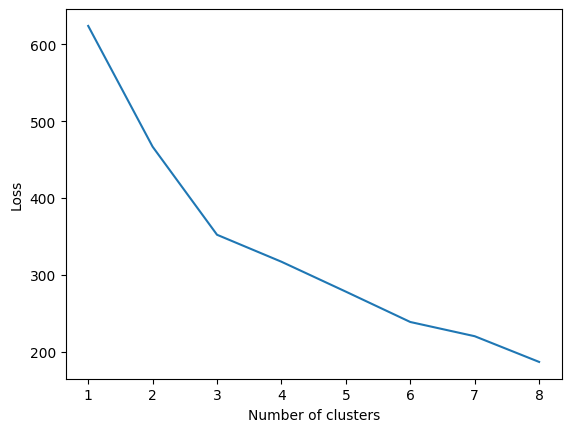

In [184]:
# Grid search for the optimum number of clusters with KMean  
# Source: Data Mining for Business Analytics by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel: Chapter 15.10

k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
    model.fit(spatial_start_hour_weekend_unstacked_clustering_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

3 Clusters for the weekend trips

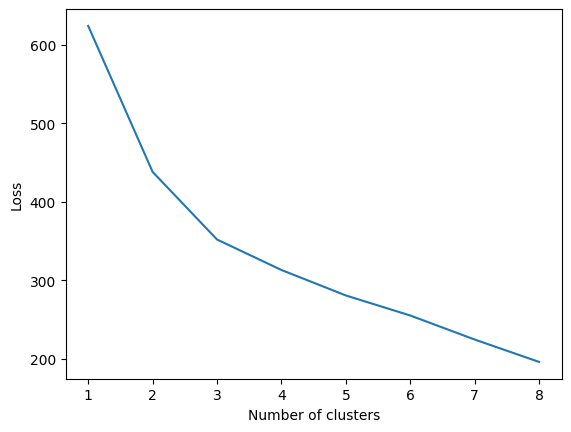

In [185]:
# Grid search for the optimum number of clusters with KMean  
# Source: Data Mining for Business Analytics by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel: Chapter 15.10

k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
    model.fit(spatial_start_hour_weekday_unstacked_clustering_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

2 Clusters as well during the week

In [186]:
spatial_hour_model_k_means = KMeans(n_clusters = 2, n_init=10, init="k-means++", random_state=42)
spatial_hour_model_k_means.fit(spatial_start_hour_weekday_unstacked_clustering_scaled_df)

weekday_T['cluster_k_means'] = spatial_hour_model_k_means.predict(spatial_start_hour_weekday_unstacked_clustering_scaled_df)

In [187]:
spatial_hour_model_bisecting_k_means = BisectingKMeans(n_clusters = 2, init="k-means++", random_state=42)
spatial_hour_model_bisecting_k_means.fit(spatial_start_hour_weekday_unstacked_clustering_scaled_df)
weekday_T['cluster_bisecting_k_means'] = spatial_hour_model_bisecting_k_means.predict(spatial_start_hour_weekday_unstacked_clustering_scaled_df)

spatial_hour_model_bisecting_k_means.cluster_centers_

array([[-1.15599979, -0.49172253, -0.30151134, -1.21467038, -0.13068205,
         0.02753453, -0.57309579, -0.71994258, -0.66074936, -0.53615694,
        -0.9927742 , -1.25355441, -0.48771311, -1.07130718, -0.73937762,
         0.12598816,  0.45226702,  0.16222142,  0.62554324, -0.20851441,
        -0.30151134,  0.4472136 , -0.88004168, -0.51669836, -0.23214697,
        -0.88162563],
       [ 0.38533326,  0.16390751,  0.10050378,  0.40489013,  0.04356068,
        -0.00917818,  0.19103193,  0.23998086,  0.22024979,  0.17871898,
         0.33092473,  0.41785147,  0.16257104,  0.35710239,  0.24645921,
        -0.04199605, -0.15075567, -0.05407381, -0.20851441,  0.0695048 ,
         0.10050378, -0.1490712 ,  0.29334723,  0.17223279,  0.07738232,
         0.29387521]])

In [188]:
# soft clustering with gaussian mixture model
gmm_spatial_hour = GaussianMixture(n_components = 2, random_state = 42)
gmm_spatial_hour.fit(spatial_start_hour_weekday_unstacked_clustering_scaled_df)

# retrieve assigned cluster labels
weekday_T['cluster_gmm'] = gmm_spatial_hour.predict(spatial_start_hour_weekday_unstacked_clustering_scaled_df)

# check convergence
print(gmm_spatial_hour.converged_)

True


In [189]:
weekday_T

pickup_hex_7,nan,872c21002ffffff,872c21003ffffff,872c21010ffffff,872c21011ffffff,872c21014ffffff,872c21015ffffff,872c21016ffffff,872c2118affffff,872c2118bffffff,...,872c21ccbffffff,872c21cd2ffffff,872c21cd3ffffff,872c21cd8ffffff,872c21cd9ffffff,872c21cdeffffff,None,cluster_k_means,cluster_bisecting_k_means,cluster_gmm
start_1_hour,,,,,,,,,,,,,,,,,,,,,
0,68.0,6.0,1.0,22.0,1.0,2.0,8.0,33.0,130.0,174.0,...,0.0,0.0,0.0,2.0,2.0,0.0,66.0,1,1,1
1,50.0,9.0,1.0,30.0,2.0,4.0,5.0,31.0,143.0,175.0,...,0.0,0.0,0.0,3.0,1.0,0.0,81.0,1,1,1
2,55.0,6.0,0.0,17.0,2.0,5.0,11.0,26.0,130.0,160.0,...,0.0,0.0,0.0,1.0,1.0,0.0,59.0,1,1,1
3,34.0,7.0,0.0,12.0,4.0,5.0,2.0,25.0,95.0,130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,65.0,1,1,1
4,12.0,5.0,0.0,9.0,0.0,5.0,5.0,9.0,60.0,83.0,...,0.0,0.0,1.0,0.0,1.0,1.0,46.0,0,0,0
5,19.0,7.0,0.0,5.0,1.0,3.0,3.0,13.0,38.0,51.0,...,0.0,0.0,0.0,1.0,1.0,0.0,26.0,0,0,0
6,12.0,5.0,0.0,13.0,0.0,2.0,5.0,9.0,6.0,20.0,...,0.0,0.0,1.0,1.0,2.0,0.0,11.0,0,0,0
7,9.0,2.0,0.0,15.0,0.0,0.0,6.0,9.0,14.0,17.0,...,0.0,0.0,0.0,2.0,1.0,0.0,6.0,0,0,0
8,13.0,1.0,0.0,13.0,0.0,0.0,3.0,7.0,14.0,21.0,...,0.0,0.0,0.0,2.0,4.0,0.0,13.0,0,0,0


In [192]:
station_df_clusters_0 = weekday_T[weekday_T['cluster_gmm'] == 0].drop(columns=['cluster_k_means', 'cluster_bisecting_k_means','cluster_gmm','nan', 'None'])
station_df_clusters_1 = weekday_T[weekday_T['cluster_gmm'] == 1].drop(columns=['cluster_k_means', 'cluster_bisecting_k_means','cluster_gmm','nan', 'None'])

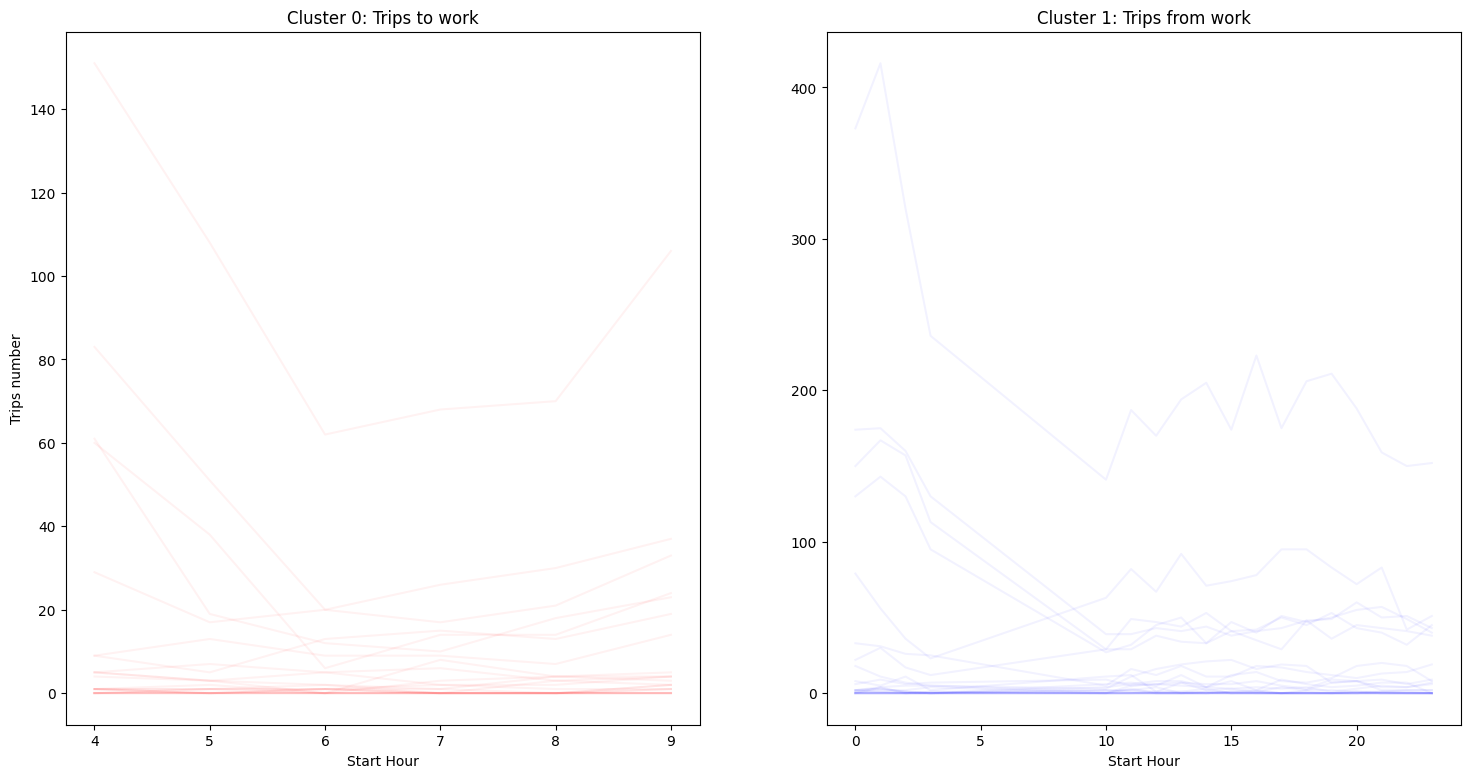

In [193]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18,9))

# plot cluster 0
station_df_clusters_0.plot(ax=ax[0],color='red', alpha=0.05)
#station_df_clusters_0["average"].plot(ax=ax[0],color='red', alpha=1)
ax[0].get_legend().remove()
ax[0].set_title('Cluster 0: Trips to work')
ax[0].set_ylabel('Trips number')
ax[0].set_xlabel('Start Hour')

# plot cluster 1 
station_df_clusters_1.plot(ax=ax[1],color='blue', alpha=0.05)
#station_df_clusters_1["average"].plot(ax=ax[1],color='blue', alpha=1)
ax[1].get_legend().remove()
ax[1].set_title('Cluster 1: Trips from work')
ax[1].set_xlabel('Start Hour')


plt.show()